In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import math
import keras
from random import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense,Bidirectional
from keras.layers import LSTM, Flatten, Input
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPooling1D,Dropout
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
model = load_model('BLSTM_1_2_3_New.h5')

In [3]:
path = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/Strike_Data_As_Np')

In [4]:
X_First = np.load(path + '/' + 'X_First_Skier.npy')
Y_First = np.load(path + '/' + 'Y_First_Skier.npy')
feature_list_First = []
with open(path + "/keys_First_Skier.txt", "r") as f:
      for line in f:
        feature_list_First.append(line.strip('\n'))

In [5]:
X_Second = np.load(path + '/' + 'X_Second_Skier.npy')
Y_Second = np.load(path + '/' + 'Y_Second_Skier.npy')
feature_list_Second = []
with open(path + "/keys_Second_Skier.txt", "r") as f:
      for line in f:
        feature_list_Second.append(line.strip('\n'))

In [6]:
X_Third = np.load(path + '/' + 'X_Third_Skier.npy')
Y_Third = np.load(path + '/' + 'Y_Third_Skier.npy')
feature_list_Third = []
with open(path + "/keys_Third_Skier.txt", "r") as f:
      for line in f:
        feature_list_Third.append(line.strip('\n'))

In [7]:
feature_Dict = {i:feature_list_Second[i] for i in range(len(feature_list_Second)-1)}
print(len(feature_Dict))

17


In [8]:
def split_to_test_train_data(X_List,Y_List,ratio,time_step,dimX,nbr_of_classes):
    # Function to split data into train and test set
    # Returns :
    # X_Test_List: Lists of numphy arrays, each numphy array has dimension (nbr_samples,time_step,dim_X),
    #              The first element of the list, contains the entire set of test points (test from all skiers),
    #              wheras the second and contains test points from skier 1 and so forth. (If you want to add data from 
    #              an additional skrier...) 
    
    nbr_of_data = len(X_List)
    min_samples = min([x.shape[0] for x in X_List])
    h = int((1-ratio)*min_samples)
    nbr_of_test = [x.shape[0]-h for x in X_List]
    X = np.zeros((h*nbr_of_data,time_step,dimX))
    Y = np.zeros((h*nbr_of_data,nbr_of_classes))
    X_Test_List = [np.zeros((sum(nbr_of_test),time_step,dimX))]
    Y_Test_List = [np.zeros((sum(nbr_of_test),nbr_of_classes))]
    
    for i in range(nbr_of_data):
        x_d = np.zeros((nbr_of_test[i],time_step,dimX))
        y_d = np.zeros((nbr_of_test[i],nbr_of_classes))
        X_Test_List.append(x_d)
        Y_Test_List.append(y_d)

    test_samp_prev = 0 
    for i in range(nbr_of_data):
        x = X_List[i][:,:,:dimX]
        y = Y_List[i]
        test_samp = nbr_of_test[i] + test_samp_prev
        X[h*i:h*(i+1),:,:] = x[:h,:,:]
        Y[h*i:h*(i+1),:] = y[:h,:]
        X_Test_List[0][test_samp_prev:test_samp,:,:] = x[h:,:,:]
        Y_Test_List[0][test_samp_prev:test_samp,:] = y[h:,:]
        X_Test_List[i+1] = x[h:,:,:]
        Y_Test_List[i+1] = y[h:,:]
        test_samp_prev = test_samp
        
    return X,Y,X_Test_List,Y_Test_List

In [9]:
dim_X = len(feature_Dict)
X_List = [X_First,X_Second,X_Third]
Y_List = [Y_First,Y_Second,Y_Third]
ratio = 0.2
time_step = 140
nbr_of_classes = 4
X,Y,X_Test_List,Y_Test_List = split_to_test_train_data(X_List,Y_List,ratio,time_step,dim_X,nbr_of_classes)
nbr_test = X_Test_List[0].shape[0]
X_Test = X_Test_List[0][:int((3*nbr_test)/4),:,:] # To get same X test as in train notebook
Y_Test = Y_Test_List[0][:int((3*nbr_test)/4),:] # To get same Y test as in train notebook

In [10]:
def change_time_axis_for_plot(X,delta_t):
    
    nbr_of_samples = X.shape[0]
    t = 0
    for i in range(nbr_of_samples):
        for j in range(140):
            X[i,j,0] = t*delta_t
            t = t + 1
    
    return X

In [11]:
def get_strike(strike,strike_l,pad):
    force_left = 1
    for j in range(strike_l-3):
        if strike[j,force_left] == strike[j+1,force_left] == strike[j+2,force_left] == pad:
        #if int(strike[j,1]) == int(strike[j+1,force_left]) == int(strike[j+2,force_left])  == pad :
            plot_strike = strike[0:j-1,force_left]
            time_strike = strike[0:j-1,0]
            print(j)
            break
        elif strike[strike_l-2,0] > 0.00000000:
            plot_strike = strike[:,force_left]
            time_strike = strike[:,0]
            break
    
    return plot_strike,time_strike

In [12]:
def plot_Results(X_Test,true_Y,pred_Y,figure,title):
    colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
    nameDict = {0:'Gear 2',1:'Gear 3',2:'Gear 4',3:'Double','Gear 2':0,'Gear 3':1,'Gear 4':2,'Double':3}
    delta_t = 0.02
    X_Test = change_time_axis_for_plot(X_Test,delta_t)
    nbr_of_test = X_Test.shape[0]
    strike_l = X_Test.shape[1]
    pad = 0
    nbr_of_classes = 4
    font_s = 18
    
    for c in range(nbr_of_classes):
        true_c = np.where(true_Y == c)[0]
        pred_c = np.where(pred_Y == c)[0]
        strike_true = []
        strike_pred = []
        time_true = []
        time_pred = []
        for i in range(true_c.shape[0]):
            strike = X_Test[true_c[i],:,:]
            t_strike,t_time = get_strike(strike,strike_l,pad)
            strike_true.extend(t_strike)
            time_true.extend(t_time)
        for i in range(pred_c.shape[0]):
            strike = X_Test[pred_c[i],:,:]
            p_strike,p_time = get_strike(strike,strike_l,pad)
            strike_pred.extend(p_strike)
            time_pred.extend(p_time)

        plt.figure(figure,figsize=(15, 6))
        plt.title(title + ' Predicted gear',fontsize = font_s)
        plt.scatter(time_pred,strike_pred,label = 'Predicted gear: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend(fontsize = font_s)
        plt.xlabel('Time',fontsize = font_s)
        plt.ylabel('Force left',fontsize = font_s)
        plt.xticks(fontsize = font_s)
        plt.yticks(fontsize = font_s)


        plt.figure(figure+1,figsize=(15, 6))
        plt.title(title + ' True gear',fontsize = font_s)
        plt.scatter(time_true,strike_true,label = 'True gear: ' + nameDict[c],color =  colorDict[c], alpha = 1)
        plt.legend(fontsize = font_s)
        plt.xlabel('Time',fontsize = font_s)
        plt.ylabel('Force left',fontsize = font_s)
        plt.xticks(fontsize = font_s)
        plt.yticks(fontsize = font_s)
        
    figure = figure + 2
    return figure

Accuracy First skier: 0.92 
             precision    recall  f1-score   support

          0       0.97      0.83      0.90        42
          1       0.88      0.99      0.93        67
          2       1.00      0.88      0.94        25
          3       0.86      0.92      0.89        13

avg / total       0.92      0.92      0.92       147

(147, 140, 17)
Accuracy Second skier: 0.96 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.93      1.00      0.96        27
          2       1.00      0.89      0.94        28
          3       1.00      1.00      1.00        22

avg / total       0.98      0.96      0.97        77

(77, 140, 17)


/Users/mariekorneliusson/anaconda3/envs/dml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Accuracy Third skier: 0.93 
             precision    recall  f1-score   support

          0       0.98      0.92      0.95        99
          1       0.87      0.92      0.89       156
          2       0.98      0.97      0.97        92
          3       0.93      0.92      0.92       192

avg / total       0.93      0.93      0.93       539

(539, 140, 17)
Accuracy All skiers: 0.94 


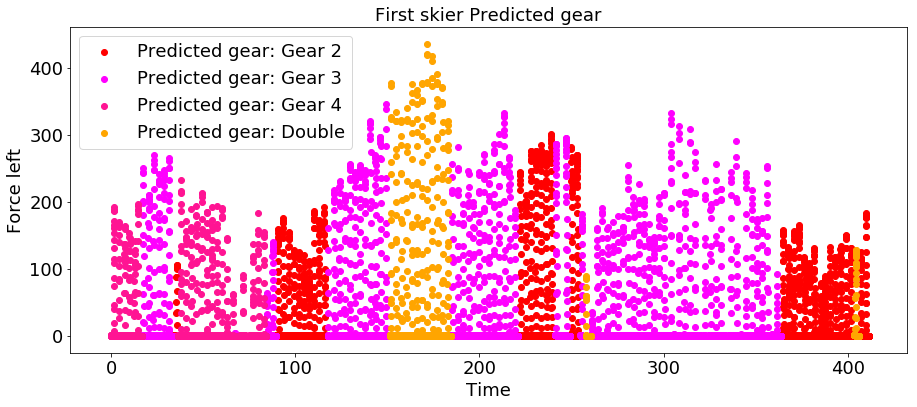

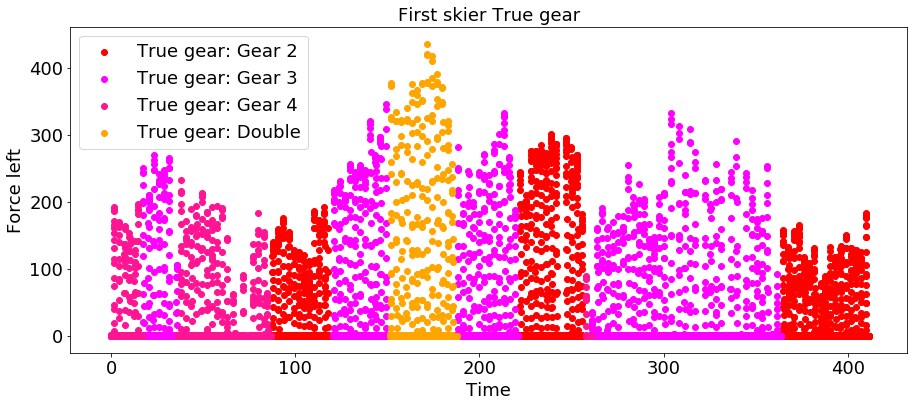

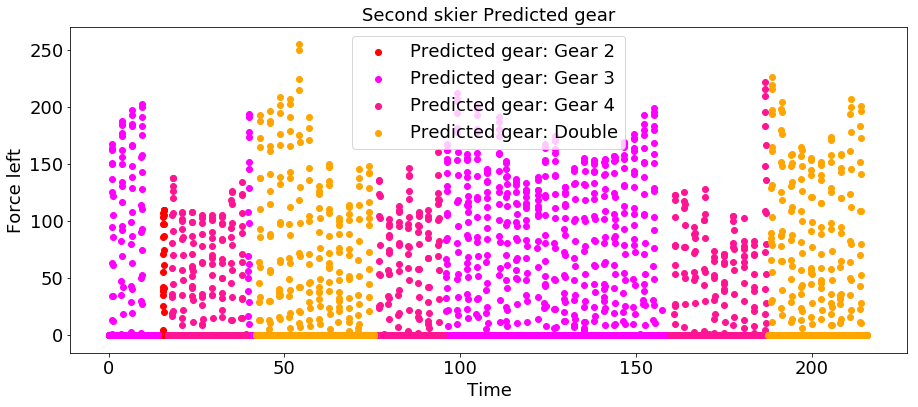

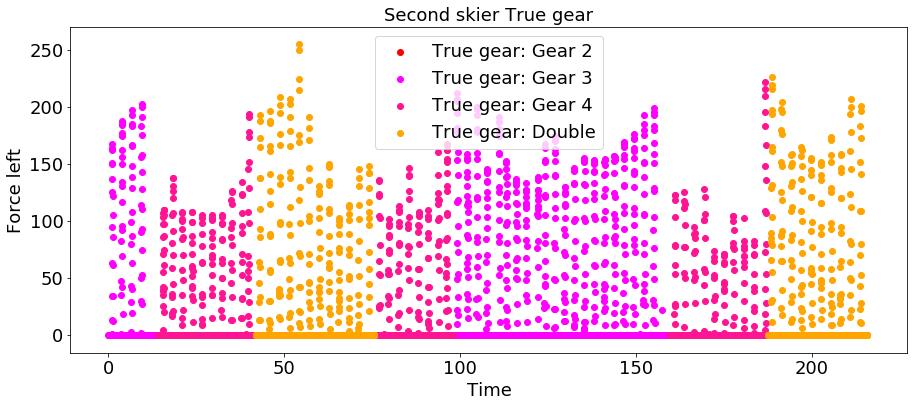

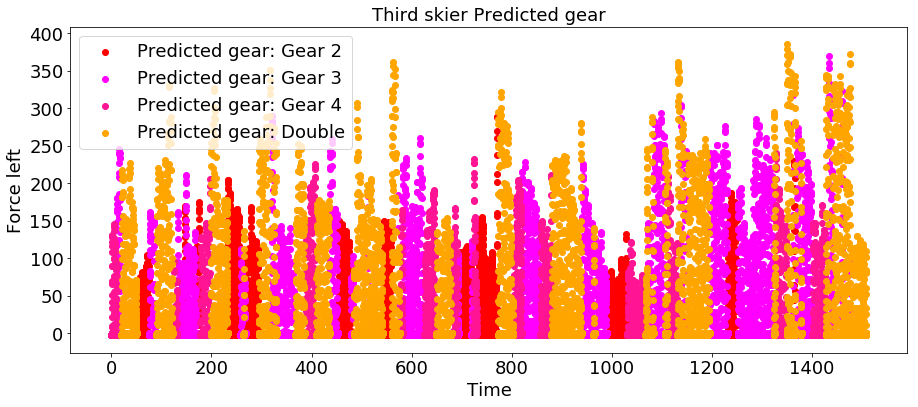

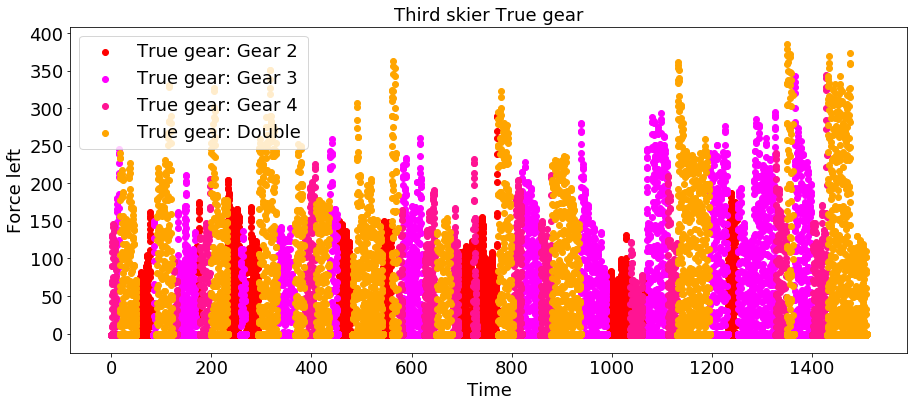

In [13]:
from sklearn.metrics import classification_report
title_List = ['All skiers','First skier','Second skier','Third skier']
figure = 0
acc_All_Skiers = 0 
for i in range(1,len(X_Test_List)):
    X_Test_Skirer = X_Test_List[i][:int((3*nbr_test)/4),:,:] 
    Y_Test_Skirer = Y_Test_List[i][:int((3*nbr_test)/4),:] 
    predY = model.predict(X_Test_Skirer[:,:,1:])
    pred_Y = np.argmax(predY,axis = 1)
    true_Y = np.argmax(Y_Test_Skirer,axis = 1)
    acc = accuracy_score(true_Y,pred_Y)
    print('Accuracy ' + title_List[i] + ': %.2f '% acc)
    print(classification_report(true_Y, pred_Y))
    print(X_Test_Skirer.shape)
    title = title_List[i]
    figure = plot_Results(X_Test_Skirer,true_Y,pred_Y,figure,title)
    acc_All_Skiers = acc_All_Skiers + acc

acc_All_Skiers = acc_All_Skiers/3
print('Accuracy ' + title_List[0] + ': %.2f '% acc_All_Skiers)

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize = 14)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize = 14)
    plt.yticks(tick_marks, classes,fontsize = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True gear',fontsize = 14)
    plt.xlabel('Predicted gear',fontsize = 14)
    plt.tight_layout()

Normalized confusion matrix
[[0.89565217 0.09565217 0.         0.00869565]
 [0.01136364 0.97159091 0.         0.01704545]
 [0.00909091 0.04545455 0.92727273 0.01818182]
 [0.         0.04678363 0.         0.95321637]]


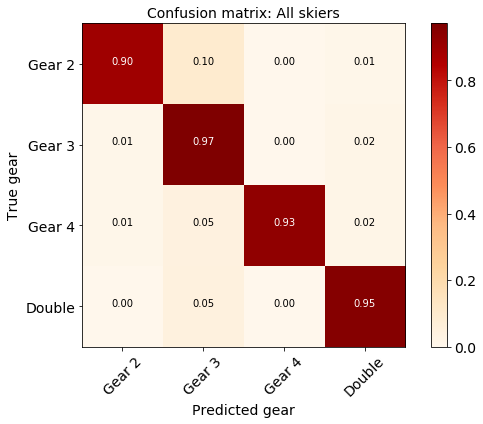

In [15]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['Gear 2','Gear 3','Gear 4','Double']

X_Test_Skirer = X_Test_List[0][:int((3*nbr_test)/4),:,:] 
Y_Test_Skirer = Y_Test_List[0][:int((3*nbr_test)/4),:] 
predY = model.predict(X_Test_Skirer[:,:,1:])
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test_Skirer,axis = 1)

cnf_matrix = confusion_matrix(true_Y, pred_Y)
plt.figure(0,figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix: All skiers')


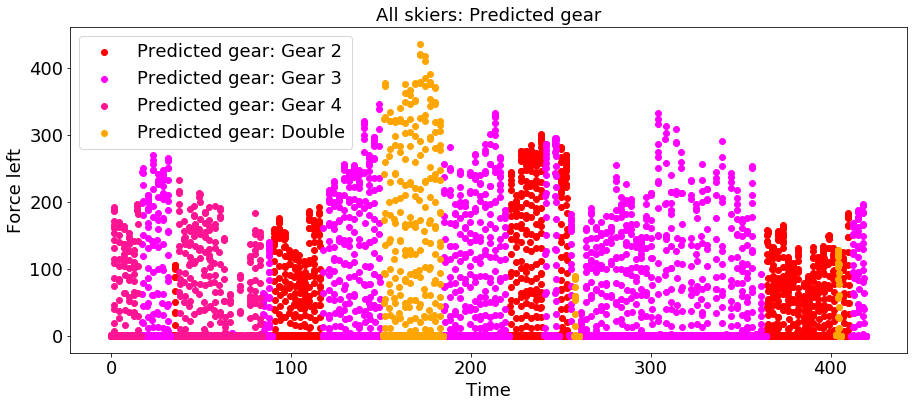

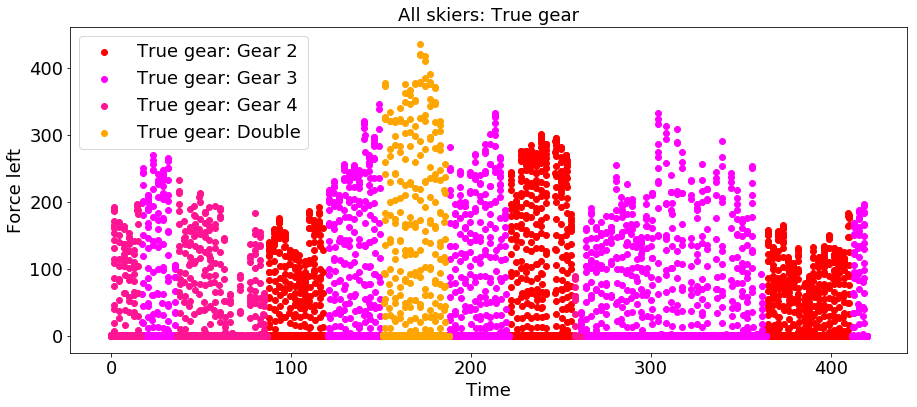

In [16]:
title = "All skiers:"
plot_points = 150
X_Test_Skirer = X_Test_List[0][:plot_points,:,:] 
Y_Test_Skirer = Y_Test_List[0][:plot_points,:] 
predY = model.predict(X_Test_Skirer[:,:,1:])
pred_Y = np.argmax(predY,axis = 1)
true_Y = np.argmax(Y_Test_Skirer,axis = 1)
figure = plot_Results(X_Test,true_Y,pred_Y,0,title)

In [17]:
def acc_data_points(X_Test,true_Y,pred_Y):
    
    tot = 0
    correct = 0
    pad = 0
    nbr_of_test = X_Test.shape[0]
    strike_l = X_Test.shape[1] # Lengt of entire strike with padding
    
    for i in range(nbr_of_test):
        strike = X_Test[i,:,:][:,1]
        
        ### To find how many data points that has been padded for the certain strike 
        v = np.where(strike == pad)[0]
        stop = -1
        count = 0
        for l in v:
            if stop == l-1:
                stop = count
                break
            else:
                count = count + 1
                stop = l
                
        pad_data = v.shape[0] - stop
        nbr_data_strike = strike_l - pad_data
        ###
        
        tot = tot + nbr_data_strike
        
        if true_Y[i] == pred_Y[i]:
            correct = correct + nbr_data_strike
    
    acc = correct/tot
    
    return acc

In [18]:
title_List = ['All skiers','First skier','Second skier','Third skier']
acc_All_Skiers = 0
for i in range(1,len(X_Test_List)):
    
    X_Test_Skirer = X_Test_List[i][:int((3*nbr_test)/4),:,:] 
    Y_Test_Skirer = Y_Test_List[i][:int((3*nbr_test)/4),:] 

    predY = model.predict(X_Test_Skirer[:,:,1:])
    pred_Y = np.argmax(predY,axis = 1)
    true_Y = np.argmax(Y_Test_Skirer,axis = 1)

    acc = acc_data_points(X_Test_Skirer,true_Y,pred_Y)
    print('Accuracy as function of data points ' + title_List[i] + ': %.2f '% acc)
    acc_All_Skiers = acc_All_Skiers + acc

acc_All_Skiers = acc_All_Skiers/3   
print('Accuracy as function of data points ' + title_List[0] + ': %.2f '% acc_All_Skiers)

Accuracy as function of data points First skier: 0.94 
Accuracy as function of data points Second skier: 0.96 
Accuracy as function of data points Third skier: 0.94 
Accuracy as function of data points All skiers: 0.95 
